## Resumo Aula 1 ML3 ##


## **1. Análise de Componentes Principais - PCA**

O termo PCA vem do inglês *Principal Component Analysis* e denomina uma técnica **não-supervisionada** que realiza uma transformação das variáveis originais num novo espaço de *features*, de modo que as novas componentes cartesianas (as *componentes principais*) sejam **ortogonais entre si** e representem a direção da **máxima variância** dos dados originais. Assim sendo:

> A primeira componente principal é um eixo cartesiano que maximiza a variância dos dados projetados em sua direção<br>A segunda componente principal é um outro eixo cartesiano, ortogonal ao primeiro, que também maximia a variância nesta direção.

<img src=https://austingwalters.com/wp-content/uploads/2014/11/gaussDist-labeled.png width=400>

Fatos importantes sobre os resultados da análise de componentes principais:

- Se o espaço original tem $n$ atributos, então será possível construir $n$ componentes principais
- Cada componente principal é uma **combinação linear dos atributos originais**. Ao contrário dos algoritmos de seleção de atributos que eliminam definitivamente as colunas do conjunto de dados, a análise de componentes principais (e outras de redução de dimensionalidade) promovem a combinação desses atributos em novos espaços
- As componentes principais são ortogonais entre si, 
- As componentes principais são linearmente independentes entre si, sendo que a PCA também pode ser utilizada para eliminar multicolinearidade antes da modelagem.

Com a aplicação da PCA, é espera-se que, no **espaço transformado das componentes principais**, a variância completa ou aproximadamente completa dos dados esteja contida nas $L$ primeiras componentes principais ($L < n$).

Em resumo, as principais aplicações da PCA podem ser elencadas:

- evitar a Maldição da Dimensionalidade
- Acelerar o treinamento de modelos, visto que os algoritmos têm menor quantidade de colunas para considerar
- Fornecer dados sem colinearidade
- Visualização de dados e análise exploratória de dados
- Eliminar ruído de medição

1.1. Interpretação das Componentes Principais**

Conforme dito, cada componente principal é uma **combinação linear dos atributos originais**. Assim sendo, o PCA pode ser interpretado como um **método que constrói um novo espaço de atributos** ou seja, um *feature map*. Isso é bem semelhante ao que é feito para os algoritmos de *Kernel SVM*. No entanto, no caso do SVM, os novos espaços criados pela aplicação da *kernel function* eram sempre de dimensão superior ao dataset original. Em contrapartida, a PCA sempre produzirá um espaço com dimensão igual ou menor ao dataset original.

<img src=https://miro.medium.com/max/1200/1*V3JWBvxB92Uo116Bpxa3Tw.png width=700>

Sabendo que os novos atributos são ortogonais entre sim, elas maximizam a variância dos dados em cada sub-espaço de projeção.

Na prática, seja um espaço de input $\mathcal{X}$ de $n$ dimensões, tal que cada vetor de features $\vec{x} \in \mathcal{X}$ é dado por:

$ \vec{x} = \left ( x_1, x_2, x_3, \cdots , x_n \right) $

Após a aplicação do PCA, estaremos no espaço de componentes principais, tal que um vetor de features neste espaço, $\vec{x}_{PC}$, será dado por:

$ \vec{x}_{PC} = \left ( PC_1, PC_2, PC_3, \cdots , PC_n \right) $

Onde cada componente principal é uma combinação linear das features originais, isto é, 

$ PC_i = \sum_{k=1}^n \alpha_{i, k} x_k = \alpha_{i, 1} x_1 +  \alpha_{i, 2} x_2 + \cdots +  \alpha_{i, n} x_n$

Note que cada componente principal $i$ tem $n$ coeficientes diferentes $\alpha_{i, k}$, que acompanham cada uma das features $k$ do espaço original. Esse coeficientes $\alpha_{i,k}$ podem ser utilizados como forma de geradores de *insights* a respeito da estrutura dos dados, sendo comumente chamados de *efeitos* ou *pesos*.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris

In [2]:
# carregar os dados
iris = load_iris(as_frame=True)
x = iris.data
y = pd.DataFrame(iris.target.values, columns=['species'])

# separando entre treino e teste
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2,
    random_state=42, stratify=y
)

No caso do dataset iris, temos 4 features, de modo que o espaço original tem 4 dimensões, e um vetor de features é:

$ \vec{x} = (x_1, x_2, x_3, x_4)$.

Sendo que:

- $x_1$ : 'sepal_length', 
- $x_2$ : 'sepal_width', 
- $x_3$ : 'petal_length', 
- $x_4$ : 'petal_width'.

Assim, esperamos que após o PCA, o espaço de componentes principais também tenha 4 dimensões, isto é, 

$ \vec{x}_{PC} = \left ( PC_1, PC_2, PC_3, PC_4 \right) $

E as componentes principais serão: 

$ PC_1 = \alpha_{1, 1} x_1 + \alpha_{1, 2} x_2 + \alpha_{1, 3} x_3 + \alpha_{1, 4} x_4$

$ PC_2 = \alpha_{2, 1} x_1 + \alpha_{2, 2} x_2 + \alpha_{2, 3} x_3 + \alpha_{2, 4} x_4$

$ PC_3 = \alpha_{3, 1} x_1 + \alpha_{3, 2} x_2 + \alpha_{3, 3} x_3 + \alpha_{3, 4} x_4$

$ PC_4 = \alpha_{4, 1} x_1 + \alpha_{4, 2} x_2 + \alpha_{4, 3} x_3 + \alpha_{4, 4} x_4$

O algoritmo de PCA é bem sensível à ordem de grandeza dos atributos, visto que ele depende do cálculo das variâncias e covariâncias, como veremos posteriormente. 

Além disso, uma das hipóteses que ele faz a respeito dos dados é que eles estejam **centrados em relação à média**. 

Portanto, a padronização é a transformação indicada para a utilização do PCA.

In [3]:
# aplicação do padronizador
scaler = StandardScaler().fit(x_train)

x_train_s = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns,
                         index=x_train.index)
x_test_s = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns,
                        index=x_test.index)

In [4]:
# aplicação do objeto da PCA
pca = PCA(random_state=42).fit(x_train_s)

O atributo `components_` nos apresenta os coeficientes das combinações lineares $\alpha_{i,k}$ 

de cada componente principal e podem ser utilizados como uma forma de análise exploratória dos dados.

In [23]:
# coeficientes das combinações lineares - efeitos ou pesos
pca.components_

range

In [20]:
for j in range(pca.n_components_):
    
    string = (f"PC_{j+1} = " 
              + 
              " + ".join([f"({alpha:.3f})*x_{i+1}" for i, alpha in enumerate(pca.components_[j])])
              +
              "\n")
    
    print(string)

PC_1 = (0.527)*x_1 + (-0.253)*x_2 + (0.582)*x_3 + (0.566)*x_4

PC_2 = (0.348)*x_1 + (0.935)*x_2 + (0.027)*x_3 + (0.066)*x_4

PC_3 = (-0.727)*x_1 + (0.222)*x_2 + (0.139)*x_3 + (0.634)*x_4

PC_4 = (0.269)*x_1 + (-0.114)*x_2 + (-0.801)*x_3 + (0.523)*x_4



Construindo-se um gráfico de combinações em pares de componentes principais, podemos usar os coeficientes para determinar pontos parecidos e, assim, inferir a respeito da estrutura dos dados. Por exemplo, espécies com maiores 'sepal_lenght' tendem a serem agrupadas com valores maiores de $PC_1$, visto que o coeficiente associado é positivo. No entanto, maiores $PC_1$ tendem a possuir exemplares com menores 'sepal_width', visto que o coeficiente associado é negativo.

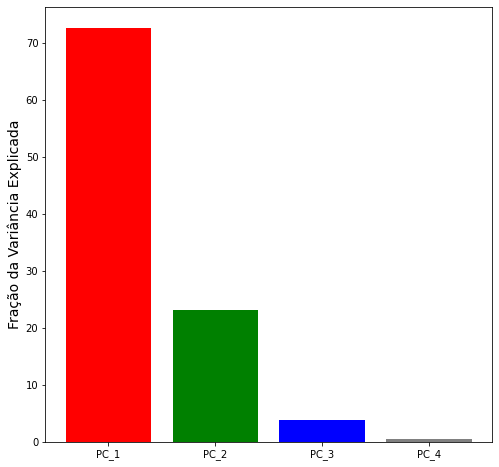

In [7]:
# criando uma lista de labels
colors = ['red', 'green', 'blue', 'gray']
labels = [f'PC_{i+1}' for i in range(pca.n_components_)]
# construindo um gráfico de variância explicada
plt.figure(figsize=(8, 8))
plt.bar(labels, pca.explained_variance_ratio_*100, color = colors)
plt.ylabel('Fração da Variância Explicada', size=14)
plt.show()

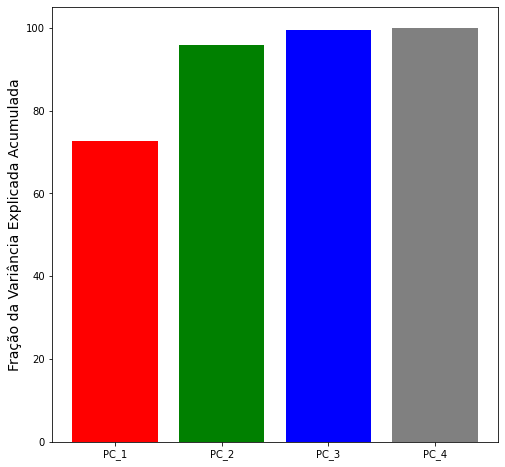

In [8]:
# construindo um gráfico de variância explicada acumulada
plt.figure(figsize=(8, 8))
plt.bar(labels, pca.explained_variance_ratio_.cumsum()*100, color = colors)
plt.ylabel('Fração da Variância Explicada Acumulada', size=14)
plt.show()

In [9]:
pca.explained_variance_ratio_.cumsum()*100

array([ 72.67723405,  95.74390107,  99.52580251, 100.        ])

Os gráficos mostram que, selecionando apenas as duas primeiras componentes principais, extraímos cerca de 95 % da informação original, porém reduzido a dimensionalidade original pela metade.

Esse tipo de análise é interessante para determinar o quanto de informação estaria sendo levada para uma possível modelagem futura. Nesse caso, estamos garantindo que modelando com 2 componentes principais, estamos retendo praticamente toda a informação inicial.

> Veja que a escolha de $L < n$ componentes principais pode ser vista como um procedimento de **feature selection**, mas feito **no espaço de componentes principais!**
> Como não são as features originais que são selecionadas, é comum nos referirmos a este procedimento como **redução de dimensionalidade** (e a dimensionalidade que é reduzida é do espaço de componentes principais)

De fato, note que **todas as 4 features originais** estão presentes em cada uma das PCs, como termos da combinação linear que define cada PC. E, naturalmente, todas as 4 estão presentes nas $L$ primeiras.

c:\Users\vitor\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 576x576 with 0 Axes>

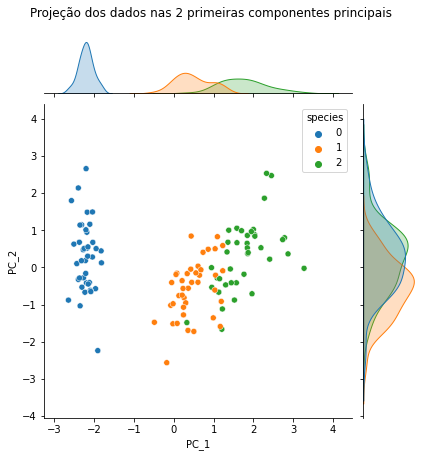

In [10]:
# transformando os dados de treino e plotando as duas primeiras componentes
x_train_pca = pd.DataFrame(pca.transform(x_train_s), columns=labels,
                           index=x_train_s.index)

# obtendo os valores das espécies
data_train_pca = pd.concat([x_train_pca, y_train], axis=1)

plt.figure(figsize=(8, 8))
g = sns.jointplot(data_train_pca['PC_1'], data_train_pca['PC_2'],
         hue=data_train_pca['species'], palette='tab10')
g.fig.suptitle('Projeção dos dados nas 2 primeiras componentes principais',
               y=1.05)
plt.show()

Nota-se, neste exemplo, que a espécie 0 ('setosa') é linearmente separável das outras, possuindo baixos valores de $PC_1$. Pela análise anterior dos pesos da primeira componente, isso nos leva à conclusão de que essa espécie comumente possuem os menores valores de 'sepal_lenght', porém os maiores valores de 'sepal_width', em relação às outras espécies.

<hr>

**Exercício 1** Utilizando a base de dados `heart.csv`, vamos tentar desenvolver um diagnosticador simples a respeito do risco de um ataque cardíaco. Para isso, aplique o algoritmo de PCA de forma exploratória, nos seguintes passos:

- cheque a presença de valores ausentes
- selecione somente atributos numéricos
- realize o escalonamento com `StandardScaler`
- por meio de gráficos bidimensionais, dê uma sugestão do que pode ser usado para diagnosticar um alto risco de ataque cardíaco.

Segue o dicionário de dados, retirado da origem dos dados ([esse link](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset?resource=download&select=heart.csv)):

- `age`: idade da pessoa
- `sex`: gênero
- `cp`: tipo de dor no peito (1 - angina típica, 2 - angina atípica, 3 - dor não angínica, 4 - sem dor)
- `exang` - se houve angina induzida por exercício (1 - sim, 0 - não)
- `trtbps` - batimentos por segundo em estado de repouso
- `chol` - concentração de colesterol
- `fbs` - concentração de açúcar no sangue > 120 mg/dl (1 - sim, 0 - não)
- `restecg` - resultados do eletrocardiograma em estado de repouso (0 - normal, 1 - anormalidades de onda do sinal; 2 - provável ou definitiva hipertrofia do ventrículo esquerdo)
- `thalachh` - máxima taxa de batimentos cardíacos alcançados
- `target` - 0 - menor chance de ataque cardíaco, 1 - maior chance

<hr>

In [11]:
data_heart = pd.read_csv('..\datasets\heart.csv')

In [12]:
data_heart

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [13]:
data_filter = data_heart.drop(columns='oldpeak')

KeyError: "['oldpeak'] not found in axis"

In [ ]:
data_filter.isna().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [ ]:
x = data_filter.drop(columns='output')
y = data_filter['output']
x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=0.3, shuffle=True, stratify=y)

In [ ]:
scaler = StandardScaler().fit(x_train)

x_train_s = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns,
                         index=x_train.index)
x_test_s = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns,
                        index=x_test.index)

pca_heart = PCA(random_state=42).fit(x_train_s)

In [ ]:
for i in range(pca_heart.n_components_):
    string = (f'PC_{i+1} ='
              +
              " + ".join([f'({alpha:.3f}) x_{j+1}' for j, alpha in enumerate(pca_heart.components_[i])])
              +
              "\n")
    print(string)


PC_1 =(0.394) x_1 + (0.079) x_2 + (-0.306) x_3 + (0.125) x_4 + (0.135) x_5 + (0.076) x_6 + (-0.161) x_7 + (-0.466) x_8 + (0.403) x_9 + (-0.301) x_10 + (0.400) x_11 + (0.223) x_12

PC_2 =(0.381) x_1 + (-0.304) x_2 + (0.328) x_3 + (0.494) x_4 + (0.330) x_5 + (0.340) x_6 + (-0.242) x_7 + (0.114) x_8 + (-0.248) x_9 + (0.096) x_10 + (0.071) x_11 + (-0.196) x_12

PC_3 =(-0.118) x_1 + (0.638) x_2 + (0.316) x_3 + (0.128) x_4 + (-0.250) x_5 + (0.414) x_6 + (-0.230) x_7 + (0.191) x_8 + (-0.039) x_9 + (-0.135) x_10 + (0.079) x_11 + (0.336) x_12

PC_4 =(0.088) x_1 + (-0.120) x_2 + (0.208) x_3 + (-0.008) x_4 + (-0.516) x_5 + (0.260) x_6 + (0.179) x_7 + (-0.349) x_8 + (0.000) x_9 + (-0.450) x_10 + (-0.198) x_11 + (-0.453) x_12

PC_5 =(0.065) x_1 + (-0.151) x_2 + (-0.041) x_3 + (0.046) x_4 + (-0.079) x_5 + (0.364) x_6 + (0.779) x_7 + (0.072) x_8 + (-0.090) x_9 + (0.153) x_10 + (0.320) x_11 + (0.292) x_12

PC_6 =(-0.077) x_1 + (-0.099) x_2 + (0.285) x_3 + (0.240) x_4 + (0.334) x_5 + (-0.228) x_6 + (0.

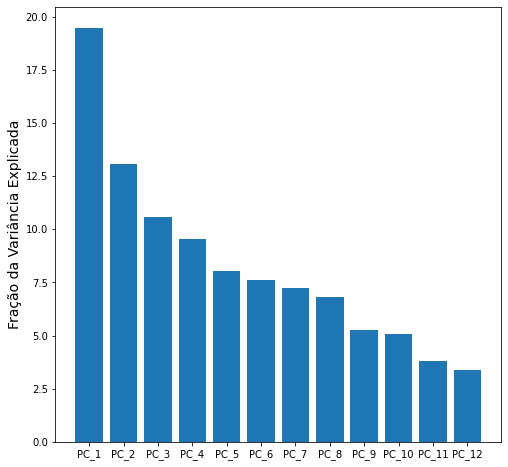

In [ ]:
labels = [f'PC_{i+1}' for i in range(pca_heart.n_components_)]
# construindo um gráfico de variância explicada
plt.figure(figsize=(8, 8))
plt.bar(labels, pca_heart.explained_variance_ratio_*100)
plt.ylabel('Fração da Variância Explicada', size=14)
plt.show()

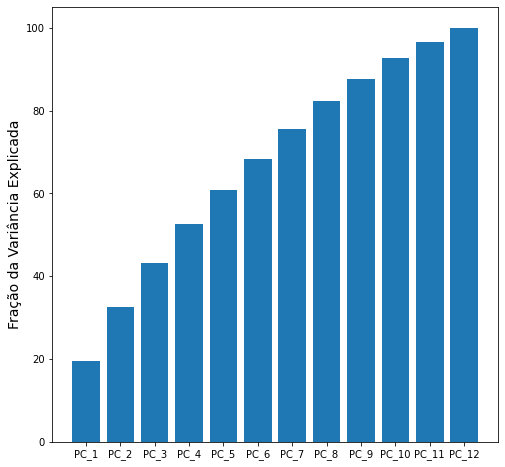

In [ ]:
labels = [f'PC_{i+1}' for i in range(pca_heart.n_components_)]
# construindo um gráfico de variância explicada
plt.figure(figsize=(8, 8))
plt.bar(labels, pca_heart.explained_variance_ratio_.cumsum()*100)
plt.ylabel('Fração da Variância Explicada', size=14)
plt.show()

In [ ]:
data_heart_pca = pd.DataFrame(pca_heart.transform(x),
                              columns=labels,
                              index=x.index)
data_heart_pca['output'] = data_heart['output']
data_heart_pca.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,output
0,4.106288,190.486462,-16.092737,-168.032739,3.607988,110.566287,45.611392,31.393084,6.759559,122.030826,-19.595230,79.837555,1
1,-22.651467,181.890989,-12.750453,-192.624034,3.319438,115.707383,48.420893,59.525831,16.867977,128.724806,-30.007364,88.554027,1
2,-20.528163,166.936910,-5.578864,-164.462969,5.840274,98.376864,50.990234,35.450507,19.515630,109.761948,-34.450408,85.071949,1
3,-14.420414,178.411724,-15.071653,-181.616954,4.885955,105.763173,39.602604,50.377103,8.602398,118.471313,-26.169640,97.806914,1
4,9.557277,215.741976,-48.570981,-237.270212,-5.341011,144.884217,26.606779,100.244995,-12.668660,160.472180,7.925753,80.623752,1


c:\Users\vitor\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 576x576 with 0 Axes>

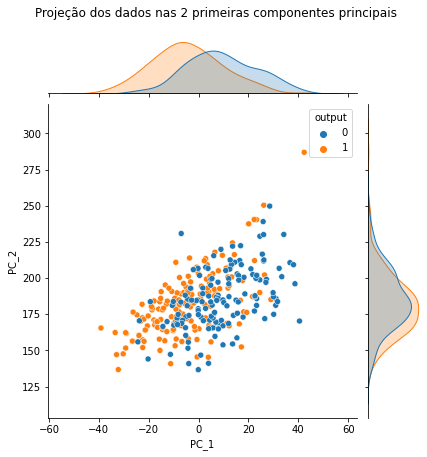

In [ ]:
plt.figure(figsize=(8, 8))
graph = sns.jointplot(data_heart_pca['PC_1'], data_heart_pca['PC_2'],
         hue=data_heart_pca['output'], palette='tab10')
graph.fig.suptitle('Projeção dos dados nas 2 primeiras componentes principais',
               y=1.05)
plt.show()

Analisando-se o efeito da idade, verifica-se que o coeficiente é positivo para a PC1 e positivo para a PC2. Isso significa que aumentar a idade (pessoas mais velhas) têm maior valor de PC1 e PC2. Pelo gráfico bidimensional, não fica claro se isso implica numa maior chance de ataque cardíaco - há muita mistura de pontos. No entanto, outro fator interessante é que a variável restecg (resultados do eletrocardiogram no estado de repouso) têm fator negativo na PC1, de forma que maiores valores apontam para menores PC1s. De fato, o gráfico mostra ligeiramente maior concentração de pontos laranja (pessoas com ataque cardíaco) em menores valores de PC1.

## **4. Selecionando o Número de Componentes**

Existem alguns métodos listados em literatura que podem ajudar na seleção do número de componentes principais a serem retidas. Vejamos os mais conhecidos:

- Seleção manual - absoluta ou por variância relativa
- Validação cruzada
- Método do cotovelo
- Método da análise paralela

### **4.1. Seleção Manual**

A seleção manual é o que já temos feito até o momento. Se for absoluta, especifica-se quantas componentes são desejadas. Se for por variância relativa, especifica-se qual a fração mínima de variância original a ser retida.

In [ ]:
# especificando-se uma retenção mínima de variância de 80 % da original
pca_var = PCA(n_components=0.80).fit(x_train_s)

print(f'Foram retidas {len(pca_var.components_)} componentes')
print(pca_var.explained_variance_ratio_)

Foram retidas 8 componentes
[0.19482092 0.13085483 0.10598973 0.09541652 0.08029718 0.07624169
 0.07235516 0.06813311]


### **4.2. Método do Cotovelo**

Bem semelhante ao realizado para os métodos de vizinhos mais próximos (kNN e KMeans), o método do cotovelo analisa quando a variância retida já não aumenta significativamente a variaância acumulada. Isso é matematicamente conhecido como *ponto de inflexão*.

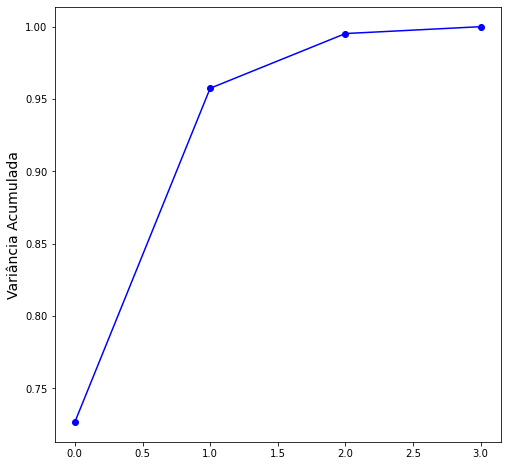

In [ ]:
# reconstruindo o gráfico de variâncias acumuladas
plt.figure(figsize=(8, 8))
plt.plot(range(4), pca.explained_variance_ratio_.cumsum(), 'bo-')
plt.ylabel('Variância Acumulada', size=14)
plt.show()

### **4.3. Validação Cruzada**

Se o propósito for utilizar a PCA em modelagem, podemos tentar selecionar o número de componentes por meio de um algoritmo de busca com validação cruzada. Neste caso, não estamos muito interessados na interpretabilidade do modelo, mas sim em desempenho. O número de componentes é visto como um *hiperparâmetro* adicional a ser buscado.

In [ ]:
# criando objeto amostrador
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# criando o pipeline de modelagem
pipe_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=42)),
    ('model', LogisticRegression(solver='saga'))
])

# criando o dicionário de parâmetros
params = {
    'pca__n_components': [1, 2, 3, 4],
    'model__C': np.random.uniform(0.01, 10, 1000),
    'model__penalty': ['l1', 'l2']
}

# criando o selecionador de modelos
model_selector = RandomizedSearchCV(
    estimator=pipe_pca,
    param_distributions=params,
    n_iter=100,
    scoring='accuracy',
    n_jobs=-1,
    refit=True,
    cv=cvs
)

# ajustando o selecionador de modelos
model_selector.fit(x_train, y_train.values.ravel())

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA(random_state=42)),
                                             ('model',
                                              LogisticRegression(solver='saga'))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model__C': array([3.86007511, 5.0970276 , 1.45904465, 8.82825267, 1.74973341,
       7.89434007, 9.87525898, 0.415...
       0.99587648, 7.82686287, 6.92960001, 1.00089238, 0.30649979,
       0.29489888, 0.15142668, 1.04648849, 2.28386312, 8.43116324,
       7.03182152, 1.30503369, 6.43248263, 6.59935044, 5.55073788,
       8.49948325, 5.57102218, 6.71423831, 5.8186154 , 8.70383968,
       1.83051064, 2.59359672, 6.39986489, 5.78930137, 8.98843233]),
                                        'model__penalty': ['l1', 'l2'],
                 

In [ ]:
# analisando os melhores hiperparâmetros
print(f'best params = {model_selector.best_params_}')
# analisando o desempenho do melhor estimador
print(f'best score = {model_selector.best_score_}')

best params = {'pca__n_components': 3, 'model__penalty': 'l1', 'model__C': 8.995696949014066}
best score = 0.8116883116883116


In [ ]:
# desempenho na base de teste
yhat = model_selector.best_estimator_.predict(x_test)

print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.89      0.80      0.85        41
           1       0.85      0.92      0.88        50

    accuracy                           0.87        91
   macro avg       0.87      0.86      0.87        91
weighted avg       0.87      0.87      0.87        91

